In [57]:
from pandas_datareader import data
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
from datetime import datetime
import urllib.request, json
import os
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [30]:
df=pd.read_csv('CleanedData.csv')
df.head()

,Unnamed: 0,Date,GoldPricePerGram,LP 95,LP 92,USDRate
0,0,2016-01-01,4907.4,138.0,127.0,144.0
1,1,2016-01-04,5025.5,138.0,127.0,144.0
2,2,2016-01-05,4974.7,138.0,127.0,144.0
3,3,2016-01-06,5051.7,138.0,127.0,144.0
4,4,2016-01-07,5112.0,138.0,127.0,144.0


In [31]:
df.drop(['Unnamed: 0'],axis=1,inplace=True)

In [32]:
df['Date'] = pd.to_datetime(df['Date']).dt.date

In [33]:
df.set_index('Date',inplace=True)

In [34]:
df.head()

,GoldPricePerGram,LP 95,LP 92,USDRate
Date,,,,
2016-01-01,4907.4,138.0,127.0,144.0
2016-01-04,5025.5,138.0,127.0,144.0
2016-01-05,4974.7,138.0,127.0,144.0
2016-01-06,5051.7,138.0,127.0,144.0
2016-01-07,5112.0,138.0,127.0,144.0


In [35]:
df.columns

Index(['GoldPricePerGram', 'LP 95', 'LP 92', 'USDRate'], dtype='object')

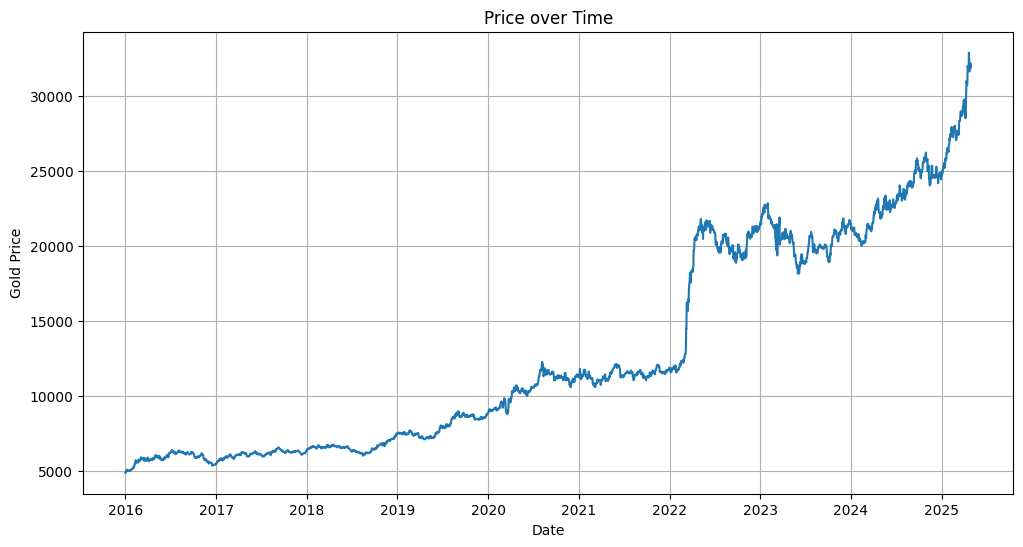

In [36]:
plt.figure(figsize=(12, 6))

df['GoldPricePerGram'].plot()

plt.xlabel("Date")
plt.ylabel("Gold Price")
plt.title("Price over Time")
plt.grid(True)

plt.show()

In [37]:
df2 = df.copy()
df.shape

(3159, 4)

In [38]:
train_data =  df.iloc[:2800,:]
val_data = df.iloc[2800:3000,:]
test_data =  df.iloc[3000:,:]

In [39]:
print(train_data.shape)
print(val_data.shape)
print(test_data.shape)

(2800, 4)
(200, 4)
(159, 4)


In [40]:
train_data.head()

,GoldPricePerGram,LP 95,LP 92,USDRate
Date,,,,
2016-01-01,4907.4,138.0,127.0,144.0
2016-01-04,5025.5,138.0,127.0,144.0
2016-01-05,4974.7,138.0,127.0,144.0
2016-01-06,5051.7,138.0,127.0,144.0
2016-01-07,5112.0,138.0,127.0,144.0


In [41]:
scaler = MinMaxScaler()

train_scaled = pd.DataFrame(scaler.fit_transform(train_data), columns=train_data.columns)
val_scaled = pd.DataFrame(scaler.transform(val_data), columns=val_data.columns)
test_scaled = pd.DataFrame(scaler.transform(test_data), columns=test_data.columns)

In [42]:
train_scaled.head()

,GoldPricePerGram,LP 95,LP 92,USDRate
0,0.000000,0.0,0.011527,0.000531
1,0.006466,0.0,0.011527,0.000531
2,0.003685,0.0,0.011527,0.000531
3,0.007900,0.0,0.011527,0.000531
4,0.011202,0.0,0.011527,0.000531


In [43]:

def squence_data(data, window_size):
  df = data.to_numpy()
  X = []
  y = []
  for i in range(len(df)-window_size):
    row = [r for r in df[i:i+window_size]]
    X.append(row)
    lbl = df[i+window_size][0]
    y.append(lbl)
  return np.array(X), np.array(y)

In [44]:
X_train, y_train = squence_data(train_scaled, 30)
X_val, y_val = squence_data(val_scaled, 30)
X_test, y_test = squence_data(test_scaled, 30)

In [45]:
len(X_train[0])

30

In [46]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow import keras

In [47]:
# Now will build the architetcure using sequentail api
model = Sequential([
    layers.Input(shape=(7,4),  name='Input Layer'),
    layers.LSTM(128, return_sequences=True, name='lstm0'),
    layers.Dropout(0.3),
    layers.LSTM(256, return_sequences=True, name = 'lstm1'),
    layers.Dropout(0.3),
    layers.LSTM(128, return_sequences=True, name = 'lstm2'),
    layers.Dropout(0.3),
    layers.LSTM(256, name = 'lstm3'),
    layers.Dropout(0.3),
    layers.Dense(1, name='Dense')
])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm0 (LSTM)                    │ (None, 7, 128)         │        68,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 7, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm1 (LSTM)                    │ (None, 7, 256)         │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 7, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm2 (LSTM)                    │ (None, 7, 128)         │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 7, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm3 (LSTM)                    │ (None, 256)            │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense (Dense)                   │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,053,953 (4.02 MB)

 Trainable params: 1,053,953 (4.02 MB)

 Non-trainable params: 0 (0.00 B)

In [48]:
model.compile(optimizer='rmsprop', loss='mse')

In [49]:
X_train.shape

(2770, 30, 4)

In [50]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)

In [51]:
history = model.fit(X_train, y_train, epochs=100,batch_size = 32, validation_data=(X_val, y_val),callbacks=[early_stopping_cb])

Epoch 1/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 0.0631 - val_loss: 0.3127
Epoch 2/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0096 - val_loss: 0.0698
Epoch 3/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0051 - val_loss: 0.0627
Epoch 4/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0049 - val_loss: 0.0334
Epoch 5/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0042 - val_loss: 0.0267
Epoch 6/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0037 - val_loss: 0.0081
Epoch 7/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0036 - val_loss: 0.0453
Epoch 8/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0037 - val_loss: 0.0337
Epoch 9/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0030 - val_loss: 0.0038
Epoch 10/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0026 - val_loss: 0.0378
Epoch 11/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0031 - val_loss: 0.0127
Epoch 12/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step

In [52]:
loss = model.evaluate(X_train, y_train, verbose=1)
print("Training Loss: ", loss)

87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.2652e-04
Training Loss:  0.0017184549942612648


In [53]:
y_pred = model.predict(X_train)
print("Predicted values: ", y_pred[:10])

87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
Predicted values:  [[0.00655062]
 [0.00966425]
 [0.01289684]
 [0.01591197]
 [0.01848282]
 [0.02049625]
 [0.0220582 ]
 [0.02316575]
 [0.02389102]
 [0.02450572]]


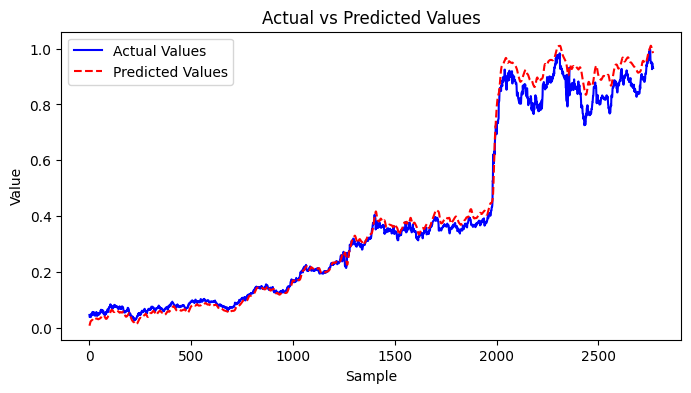

In [54]:
plt.figure(figsize=(8, 4))
plt.plot(y_train, label='Actual Values', color='blue')
plt.plot(y_pred, label='Predicted Values', color='red', linestyle='--')
plt.title('Actual vs Predicted Values')
plt.xlabel('Sample')
plt.ylabel('Value')
plt.legend()
plt.show()

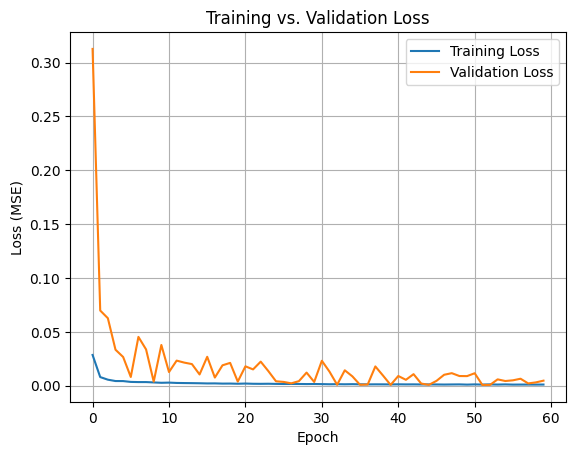

In [55]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training vs. Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


## Random Walk

In [58]:
y_pred_rw = y_val[:-1]
y_actual = y_val[1:]


rmse_rw = np.sqrt(mean_squared_error(y_actual, y_pred_rw))
mae_rw = mean_absolute_error(y_actual, y_pred_rw)

print("Random Walk RMSE:", rmse_rw)
print("Random Walk MAE :", mae_rw)

Random Walk RMSE: 0.01160247119033211
Random Walk MAE : 0.007945688292425847


In [59]:
y_pred_lstm = model.predict(X_val)

y_pred_lstm = y_pred_lstm.flatten()
y_val = y_val.flatten()

rmse_lstm = np.sqrt(mean_squared_error(y_val, y_pred_lstm))
mae_lstm = mean_absolute_error(y_val, y_pred_lstm)

print("LSTM RMSE:", rmse_lstm)
print("LSTM MAE :", mae_lstm)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
LSTM RMSE: 0.027429617756340573
LSTM MAE : 0.022760426049734214


In [60]:
if rmse_lstm < rmse_rw:
    print("LSTM beats the Random Walk baseline!")
else:
    print("LSTM does NOT beat the Random Walk baseline")


LSTM does NOT beat the Random Walk baseline
